In [1]:

#算法辅助&数据
import sklearn
from sklearn.model_selection import KFold,cross_validate   #交叉验证
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report
from sklearn.model_selection import train_test_split     #训练集测试集拆分

#算法（学习器）                          
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pip install openbb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 23.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 36.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 34.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 23.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 837.9/837.9 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 37.3 MB/s eta 0:00:00 0:00:01
  Created wheel for peewee: filename=peewee-3.17.9-cp312-cp312-macosx_11_0_arm64.whl size=264368 sha256=5ff22fd931ab40821e32f5b7f9dc6e98d8119789dcc49b279be955e2c6ec0865
  Stored in directory: /Users/jerrytang/Library/Caches/pip/wheels/43/ef/2d/2c51d496bf084945ffdf838b4cc8767b8ba1cc20eb

### 1 数据导入

In [2]:
# 基准指数
index_item = '000300.XSHG'
# 机器学习数据
data = pd.read_pickle('./300/Financials/data/ml_data.pkl')
# 研究周期
date_list = sorted(set(data.index.get_level_values(0)))                                    # 研究周期确定

                                                              # 研究周期确定
# 特征集
x = data.loc[:,:'general_reserve_ttm_0']                                                   # 去除文本数据，保留因子数据
# total_equity_ttm_0
y = data.loc[:,'target']                                                                   # Y对象为binary数据1，0
# 样本分离
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)         # 拆分训练集和测试集
# 特征名称
features = x_train.columns.tolist()                                                        # 建立特征集

### 2 决策树

**模型调参注意事项:**

1. 当样本少数量但是样本特征非常多的时候，决策树很容易过拟合，一般来说，样本数比特征数多一些会比较容易建立健壮的模型

2. 如果样本数量少但是样本特征非常多，在拟合决策树模型前，推荐先做维度规约，比如主成分分析（PCA），特征选择（Losso）。这样特征的维度会大大减小。再来拟合决策树模型效果会好。

3. 推荐多用决策树的可视化，同时先限制决策树的深度（比如最多3层），这样可以先观察下生成的决策树里数据的初步拟合情况，然后再决定是否要增加深度。

4. 在训练模型先，注意观察样本的类别情况（主要指分类树），如果类别分布非常不均匀，就要考虑用class_weight来限制模型过于偏向样本多的类别。


In [3]:
DecisionTreeClassifier?

Init signature:
DecisionTreeClassifier(
    *,
    criterion='gini',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    class_weight=None,
    ccp_alpha=0.0,
    monotonic_cst=None,
)
Docstring:     
A decision tree classifier.

Read more in the :ref:`User Guide <tree>`.

Parameters
----------
criterion : {"gini", "entropy", "log_loss"}, default="gini"
    The function to measure the quality of a split. Supported criteria are
    "gini" for the Gini impurity and "log_loss" and "entropy" both for the
    Shannon information gain, see :ref:`tree_mathematical_formulation`.

splitter : {"best", "random"}, default="best"
    The strategy used to choose the split at each node. Supported
    strategies are "best" to choose the best split and "random" to choose
    the best random split.

max_depth : int, default=None

In [4]:
clf = DecisionTreeClassifier(criterion = 'gini',
                             class_weight = 'balanced',
                             max_depth = 6,
                             random_state = 0,
                             )

clf.fit(x_train,y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=6, random_state=0)

In [5]:
#特征提取
def feature_importances(clf):
    features_important=clf.feature_importances_             
    features_important_df = pd.DataFrame([features,features_important],index=['feature','feature_importance']).T  #建立特征值表   
    features_important_df = features_important_df.sort_values(by = 'feature_importance') 

    #画图
    ind = np.arange(len(features_important_df['feature']))    
    width = 0.35 
    ax = plt.figure(figsize=(len(features_important_df['feature'])/3,len(features_important_df['feature'])/2))
    plt.barh(ind, features_important_df['feature_importance'], width , color='IndianRed', label='Feature_importance')

    plt.yticks(ind,([feature for feature in features_important_df['feature']]))
    plt.tick_params(labelsize=8)
    plt.show()

In [6]:
clf

DecisionTreeClassifier(class_weight='balanced', max_depth=6, random_state=0)

In [7]:
?feature_importances

Signature: feature_importances(clf)
Docstring: <no docstring>
File:      /var/folders/1f/5ggn6k991fv0z5vzr6xpyxx80000gn/T/ipykernel_28243/616848119.py
Type:      function

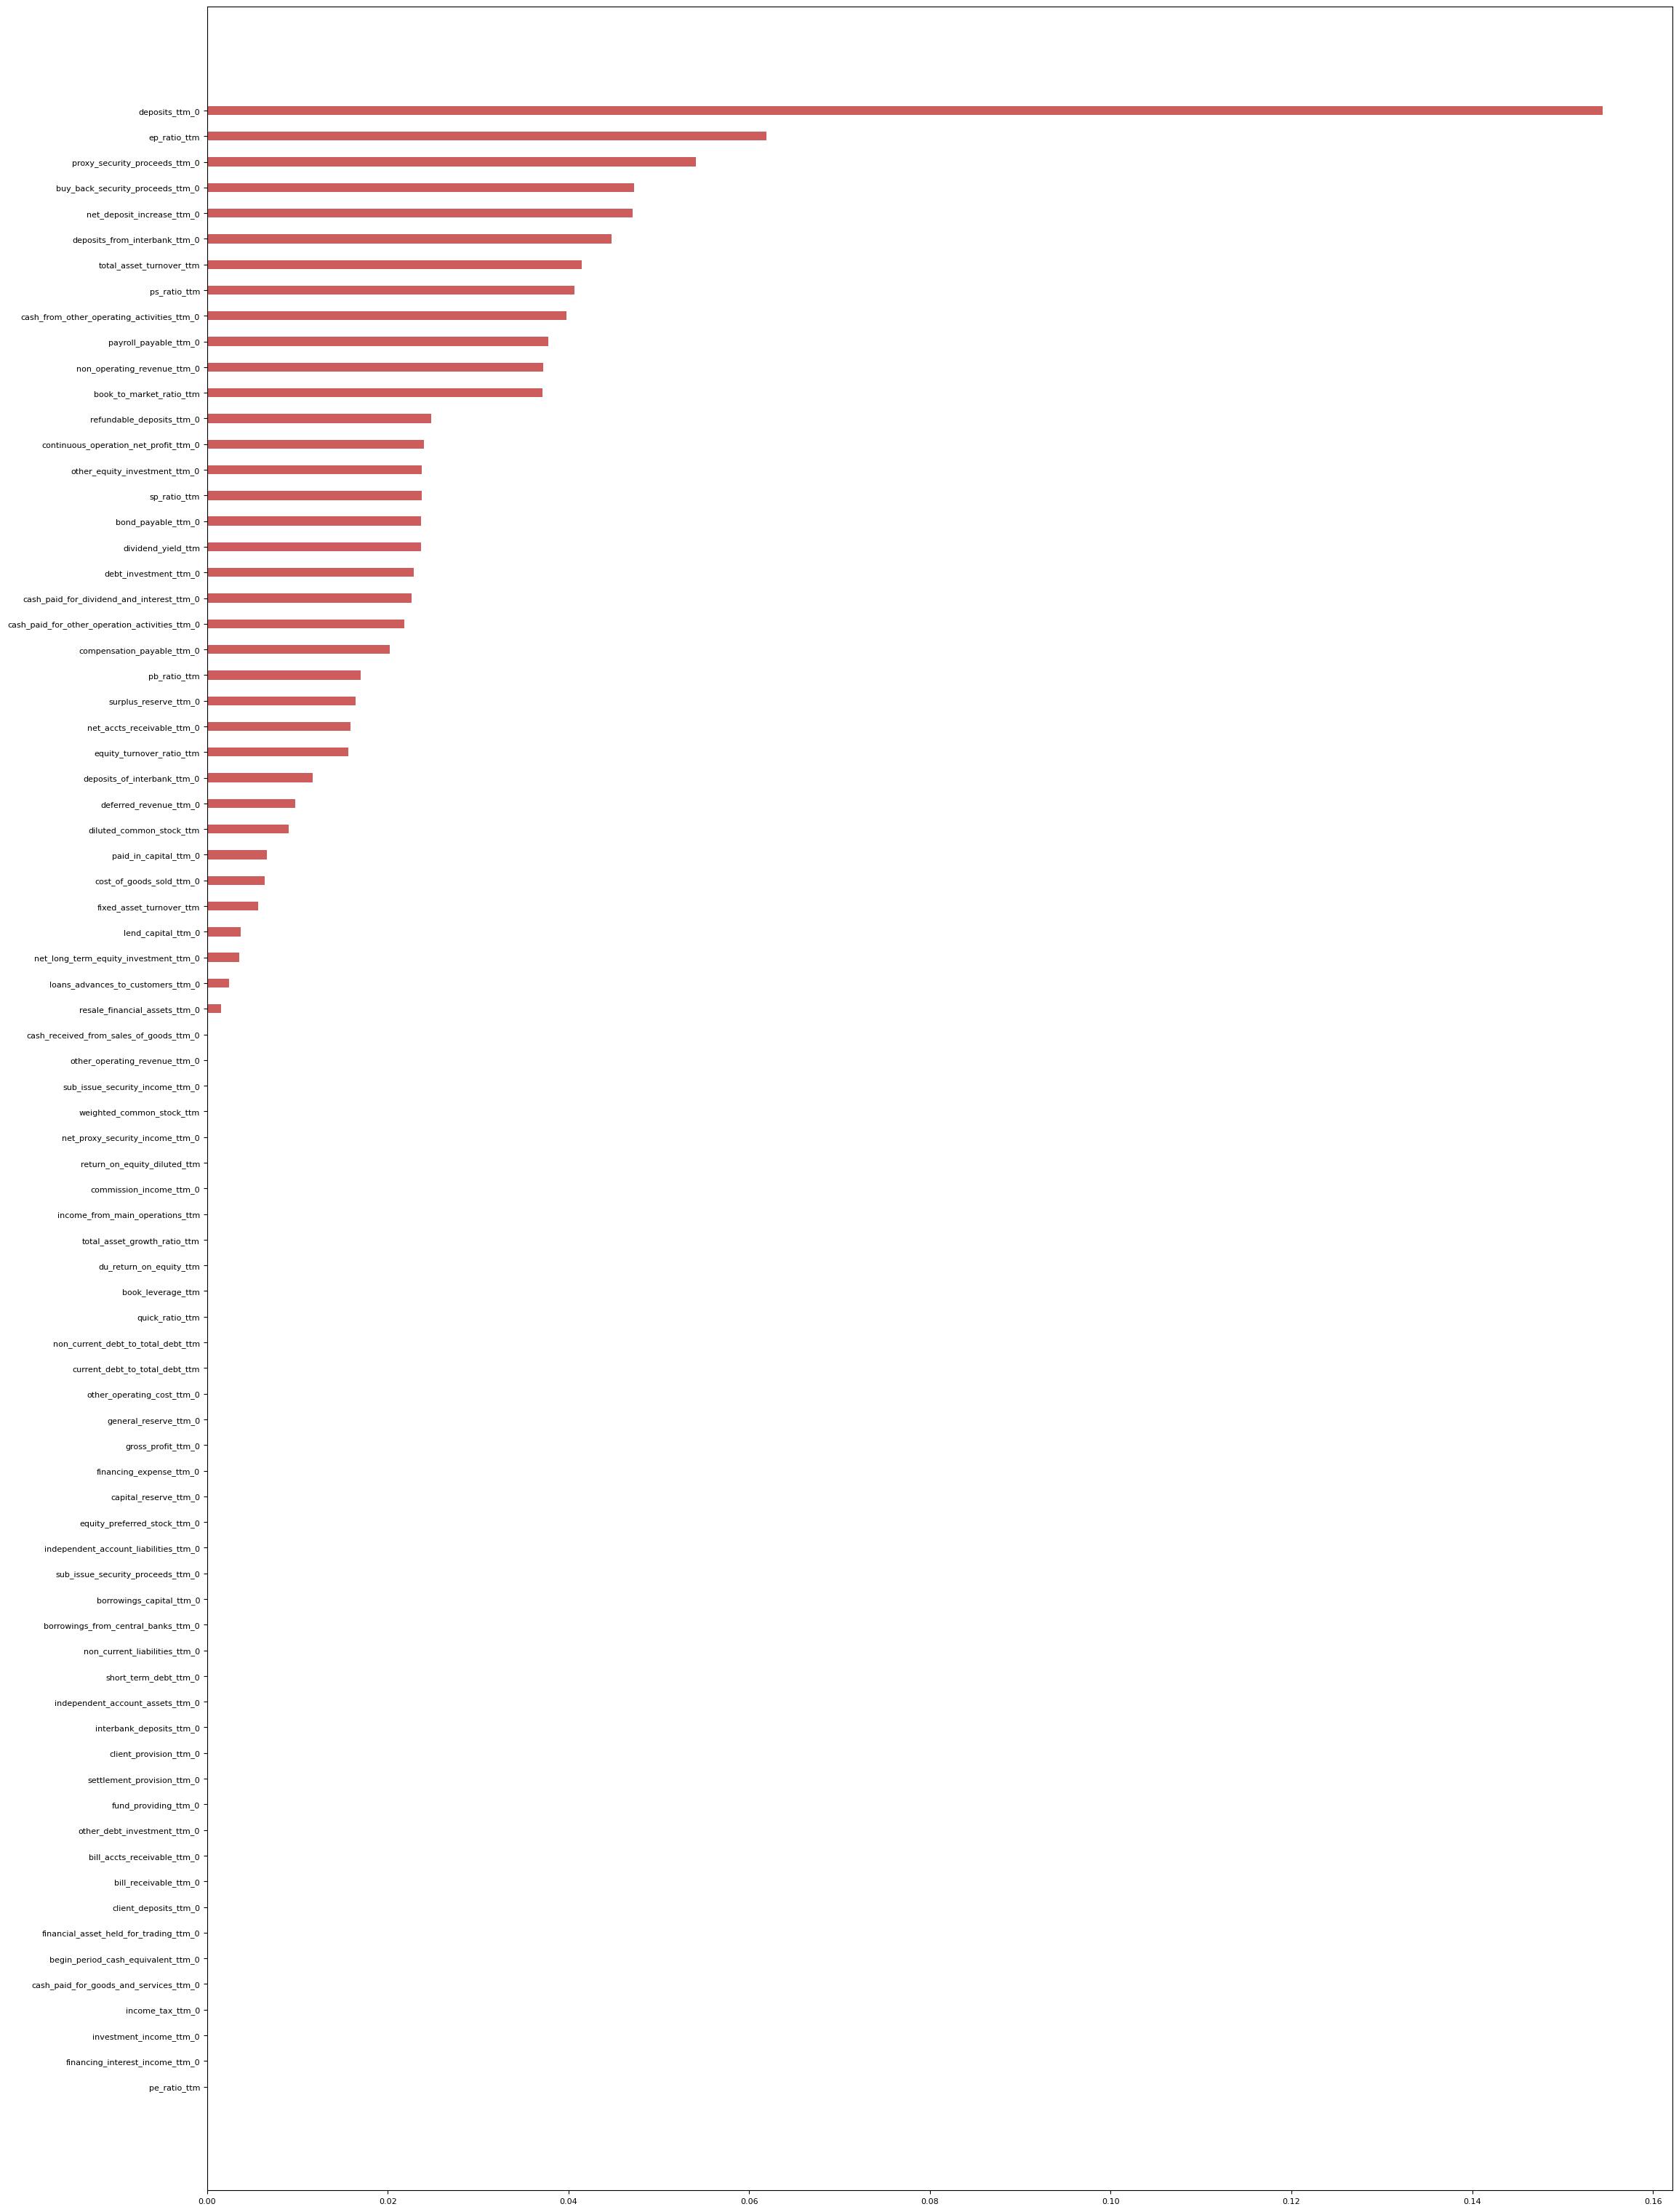

In [8]:
feature_importances(clf)

In [9]:
ic_summary_5 = pd.read_csv('./300/Financials/data/report/ic_summary_5.csv',index_col=[0]).sort_values(by = 'IR')
ic_summary_5

,IC mean,IC std,IR,IC>0,ABS_IC>2%,t_stat
name,,,,,,
bill_receivable_ttm_0,-0.2105,0.7269,-0.2896,0.3421,1.0000,-2.5248
pb_ratio_ttm,-0.0448,0.1879,-0.2385,0.4037,0.8989,-8.4527
pe_ratio_ttm,-0.0337,0.1727,-0.1951,0.4403,0.9084,-6.9153
fixed_asset_turnover_ttm,-0.0210,0.1517,-0.1386,0.4347,0.9076,-4.9122
total_asset_growth_ratio_ttm,-0.0202,0.1465,-0.1381,0.4506,0.8854,-4.8938
...,...,...,...,...,...,...
settlement_provision_ttm_0,0.0561,0.2298,0.2440,0.6032,0.9307,8.6452
client_deposits_ttm_0,0.0745,0.2936,0.2538,0.5952,0.9530,8.9895
fund_providing_ttm_0,0.0753,0.2768,0.2719,0.6048,0.9466,9.6339


In [10]:
def evaluation(clf,x_train,y_train,x_test,y_test):
    """
    对融合模型做交叉验证，对融合模型表现进行评估
    """
    cv = KFold(n_splits = 5,shuffle = True,random_state = 666)                  #5折交叉验证
    result = cross_validate(clf,
                            x_train,
                            y_train,
                            cv = cv,
                            scoring = 'precision',
                            n_jobs = -1,
                            return_train_score = True,
                            verbose = False
                            )
    # 训练集CV
    train_signal = confusion_matrix(list(y_train),list(clf.predict(x_train)))
    confusion_data_train = pd.DataFrame(train_signal,
                                        index=['real_zero','real_one'],
                                        columns=['predict_zero','predict_one'])
    
    print('\n ----------- train -----------')
    print('\n',confusion_data_train)
    print('\n train_cv_score: {}'.format(result['train_score'].mean()))
    # 测试集
    predict = clf.predict(x_test)                                                 
    print('\n ----------- test -----------')    
    print(classification_report(y_test,predict))

In [11]:
evaluation(clf,x_train,y_train,x_test,y_test)


 ----------- train -----------

            predict_zero  predict_one
real_zero         16378        11908
real_one          11584        13658

 train_cv_score: 0.5359532492256964

 ----------- test -----------
              precision    recall  f1-score   support

       False       0.58      0.57      0.58      7064
        True       0.53      0.53      0.53      6318

    accuracy                           0.55     13382
   macro avg       0.55      0.55      0.55     13382
weighted avg       0.55      0.55      0.55     13382



In [12]:
# 测试集合预测
x_test_copy = x_test.copy()
x_test_copy['predict'] = clf.predict(x_test_copy)

In [13]:
def get_siganl_delay(x_test,T = 5):
    # 时间获取
    start_date = x_test.index.get_level_values(0).min()
    end_date = x_test.index.get_level_values(0).max()
    date_list = pd.to_datetime(get_trading_dates(start_date,end_date))
    # 信号数字化
    predict_signal = x_test['predict'].astype(int)
    # 信号递延
    predict_signal = predict_signal.unstack().fillna(0).reindex(date_list).unstack()
    predict_signal_delay = pd.DataFrame({i:predict_signal.groupby(level=0).apply(lambda x:x.shift(i)) for i in range(1,T+1)}).sort_index()
    # 信号叠加
    predict_signal_delay['signal_level'] = predict_signal_delay.sum(axis = 1) 
    predict_signal_cum = predict_signal_delay.signal_level.unstack('order_book_id')
    # predict_signal_cum.stack().replace(0,np.nan).hist(bins = 5)
    # predict_signal_cum.stack().value_counts().sort_index()

    return predict_signal_cum,predict_signal_delay

In [14]:
predict_signal_cum,predict_signal_delay = get_siganl_delay(x_test_copy)

NameError: name 'get_trading_dates' is not defined

In [ ]:
predict_signal_delay

1    2    3    4    5  signal_level
order_book_id                                                  
000063.XSHE   2020-06-01  NaN  NaN  NaN  NaN  NaN           0.0
              2020-06-02  1.0  NaN  NaN  NaN  NaN           1.0
              2020-06-03  0.0  1.0  NaN  NaN  NaN           1.0
              2020-06-04  1.0  0.0  1.0  NaN  NaN           2.0
              2020-06-05  0.0  1.0  0.0  1.0  NaN           2.0
...                       ...  ...  ...  ...  ...           ...
688981.XSHG   2025-02-24  0.0  0.0  0.0  0.0  0.0           0.0
              2025-02-25  0.0  0.0  0.0  0.0  0.0           0.0
              2025-02-26  0.0  0.0  0.0  0.0  0.0           0.0
              2025-02-27  0.0  0.0  0.0  0.0  0.0           0.0
              2025-02-28  0.0  0.0  0.0  0.0  0.0           0.0

[95533 rows x 6 columns]

In [15]:
predict_signal_cum.stack().replace(0,np.nan).hist(bins = 5)
predict_signal_cum.stack().value_counts().sort_index()

NameError: name 'predict_signal_cum' is not defined

In [16]:
# 回测检验
buy_list = (predict_signal_cum != 0).astype(int)
df_wight = buy_list.div(buy_list.sum(axis = 1),axis = 0).replace(0,np.nan)
account_result = backtest(df_wight,5)
performance_cumnet,result = get_performance_analysis(account_result,index_item)
performance_cumnet.plot(secondary_y='alpha')
result

NameError: name 'predict_signal_cum' is not defined

#### 2.1 调整模型参数

##### 2.1.1 max_depth = 3

In [21]:
clf = DecisionTreeClassifier(criterion = 'gini',
                             class_weight = 'balanced',
                             max_depth = 3,
                             random_state = 0,
                             )

clf.fit(x_train,y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=3, random_state=0)

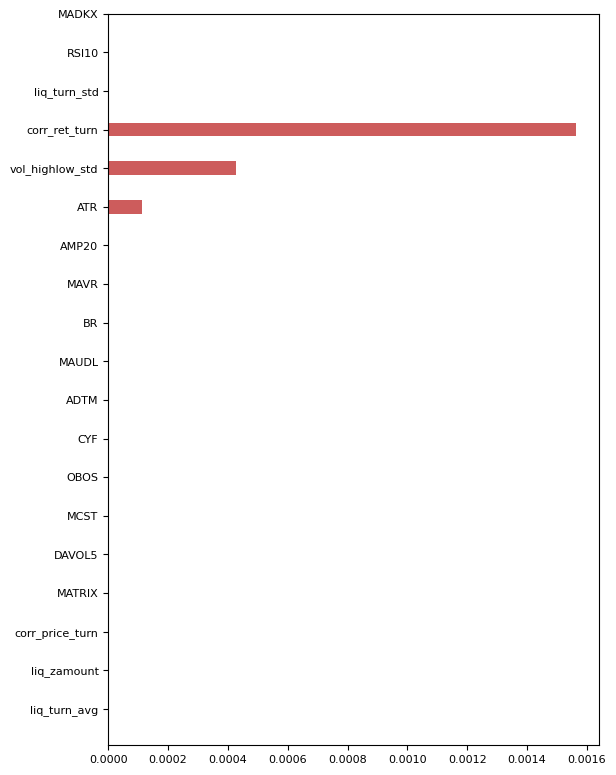

In [22]:
feature_importances(clf)

In [23]:
evaluation(clf,x_train,y_train,x_test,y_test)


 ----------- train -----------

            predict_zero  predict_one
real_zero          3025          677
real_one           2431          911

 train_cv_score: 0.5512417575805307

 ----------- test -----------
              precision    recall  f1-score   support

       False       0.55      0.77      0.64       933
        True       0.52      0.27      0.36       828

    accuracy                           0.54      1761
   macro avg       0.53      0.52      0.50      1761
weighted avg       0.53      0.54      0.51      1761



100%|██████████| 36/36 [00:00<00:00, 182.99it/s]


{'策略累计收益': 0.2917,
 '策略年化收益': 0.4282,
 '基准累计收益': 0.0951,
 '基准年化收益': 0.1349,
 '阿尔法': 0.248,
 '贝塔': 0.8596,
 '波动率': 0.2943,
 '夏普比率': 1.3529,
 '下行波动率': 0.2014,
 '索提诺比率': 1.9767,
 '跟踪误差': 0.1484,
 '信息比率': 1.9762,
 '最大回撤': 0.1724,
 '卡玛比率': 2.4835,
 '超额累计收益': 0.1795,
 '超额年化收益': 0.2584,
 '超额波动率': 0.1459,
 '超额夏普': 1.5658,
 '超额最大回测': 0.1196,
 '胜率': 0.5611,
 '盈亏比': 1.0554}

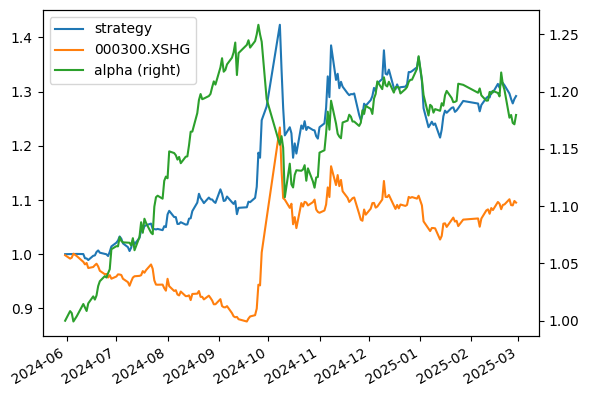

In [24]:
# 测试集合预测
x_test_copy = x_test.copy()
x_test_copy['predict'] = clf.predict(x_test_copy)
# 信号递延
predict_signal_cum,predict_signal_delay = get_siganl_delay(x_test_copy)

# 回测检验
buy_list = (predict_signal_cum != 0).astype(int)
df_wight = buy_list.div(buy_list.sum(axis = 1),axis = 0).replace(0,np.nan)
account_result = backtest(df_wight,5)
performance_cumnet,result = get_performance_analysis(account_result,index_item)
performance_cumnet.plot(secondary_y='alpha')
result

##### 2.1.2 max_depth = 20

In [25]:
clf = DecisionTreeClassifier(criterion = 'gini',
                             class_weight = 'balanced',
                             max_depth = 20,
                             random_state = 0,
                             )

clf.fit(x_train,y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=20, random_state=0)

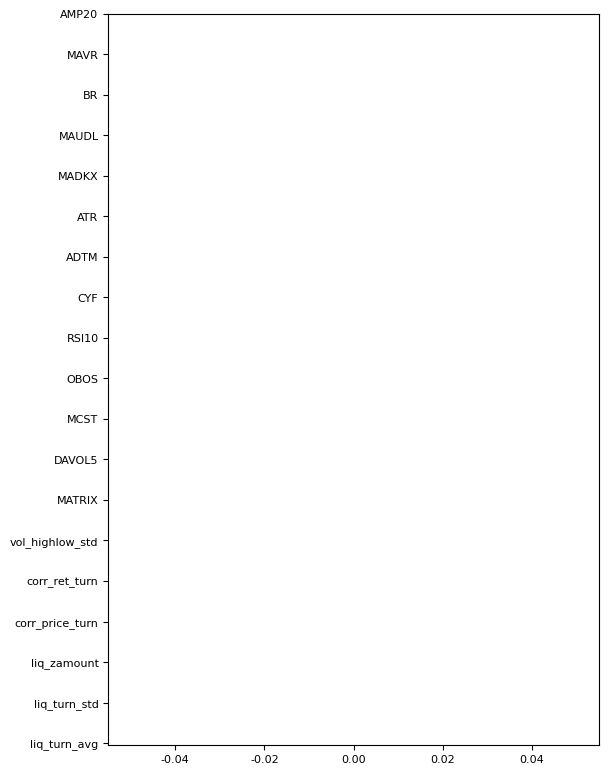

In [26]:
feature_importances(clf)

100%|██████████| 36/36 [00:00<00:00, 196.50it/s]


{'策略累计收益': 0.5937,
 '策略年化收益': 0.9133,
 '基准累计收益': 0.0951,
 '基准年化收益': 0.1349,
 '阿尔法': 0.5348,
 '贝塔': 0.9444,
 '波动率': 0.311,
 '夏普比率': 2.8407,
 '下行波动率': 0.1714,
 '索提诺比率': 5.1527,
 '跟踪误差': 0.1299,
 '信息比率': 5.9933,
 '最大回撤': 0.1223,
 '卡玛比率': 7.469,
 '超额累计收益': 0.4552,
 '超额年化收益': 0.6859,
 '超额波动率': 0.1286,
 '超额夏普': 5.1025,
 '超额最大回测': 0.0375,
 '胜率': 0.6278,
 '盈亏比': 1.1883}

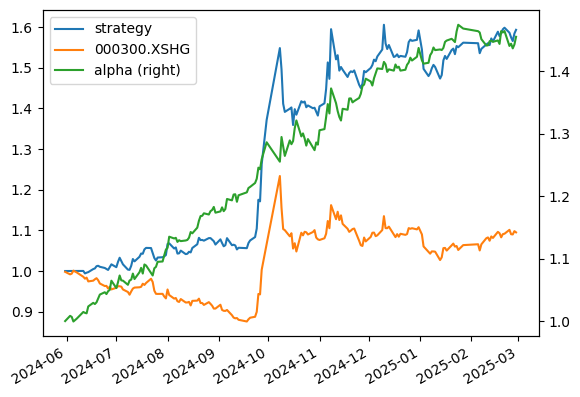

In [27]:
# 测试集合预测
x_test_copy = x_test.copy()
x_test_copy['predict'] = clf.predict(x_test_copy)
# 信号递延
predict_signal_cum,predict_signal_delay = get_siganl_delay(x_test_copy)

# 回测检验
buy_list = (predict_signal_cum != 0).astype(int)
df_wight = buy_list.div(buy_list.sum(axis = 1),axis = 0).replace(0,np.nan)
account_result = backtest(df_wight,5)
performance_cumnet,result = get_performance_analysis(account_result,index_item)
performance_cumnet.plot(secondary_y='alpha')
result

#### 2.2 参数遍历

##### 2.2.1 for 循环编辑

In [28]:
# For遍历
# 基准指数
index_item = '000300.XSHG'
# 机器学习数据
data = pd.read_pickle('./data/ml_data.pkl')
# 研究周期
date_list = sorted(set(data.index.get_level_values(0)))                                    # 研究周期确定
# 特征集
x = data.loc[:,:'AMP20']                                                                   # 去除文本数据，保留因子数据
# 目标集合
y = data.loc[:,'target']                                                                   # Y对象为binary数据1，0
# 样本分离
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)         # 拆分训练集和测试集
# 特征名称
features = x_train.columns.tolist()                                                        # 建立特征集

record = {}
max_depth_performance = pd.DataFrame()
for i in tqdm(range(3,20,2)):
    clf = DecisionTreeClassifier(criterion = 'gini',
                             class_weight = 'balanced',
                             max_depth = i,
                             random_state = 0,
                             )

    clf.fit(x_train,y_train)

    # 测试集合预测
    x_test_copy = x_test.copy()
    x_test_copy['predict'] = clf.predict(x_test_copy)
    # 信号递延
    predict_signal_cum,predict_signal_delay = get_siganl_delay(x_test_copy)

    # 回测检验
    buy_list = (predict_signal_cum != 0).astype(int)
    df_wight = buy_list.div(buy_list.sum(axis = 1),axis = 0).replace(0,np.nan)
    account_result = backtest(df_wight,5)
    performance_cumnet,result = get_performance_analysis(account_result,index_item)
    # 存入累计表现
    max_depth_performance[i] = performance_cumnet['strategy']
    # 存入累计收益
    record[i] = result['策略累计收益']
max_depth_performance['000300.XSHG'] = performance_cumnet['000300.XSHG']

100%|██████████| 9/9 [00:04<00:00,  1.99it/s]


<AxesSubplot:>

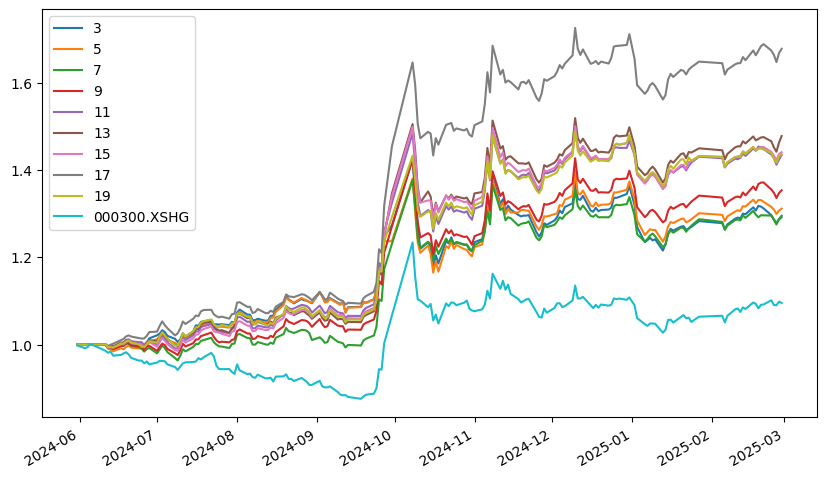

In [29]:
max_depth_performance.plot(figsize = (10,6))

<AxesSubplot:>

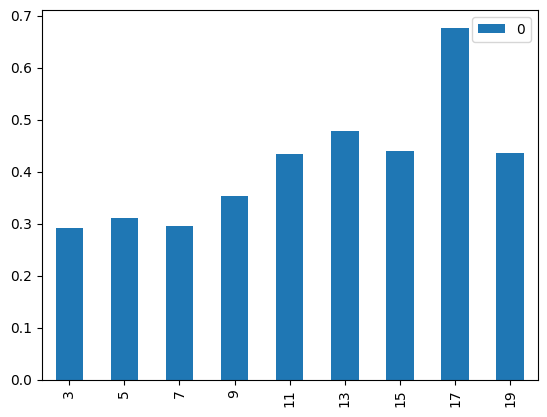

In [30]:
pd.DataFrame([record]).T.plot(kind = 'bar')

##### 2.2.2 网格搜索

In [ ]:
from sklearn.model_selection import GridSearchCV

# 网格搜索法
dt_grid = {
           'max_depth':np.arange(3,20,3),
           'ccp_alpha':np.logspace(-5,-3,5)
           }

dt_gscv = GridSearchCV(DecisionTreeClassifier(criterion = 'gini',
                                              class_weight = 'balanced',
                                              random_state = 0),
                        param_grid = dt_grid,
                        scoring = 'precision',
                        cv = 5,
                        n_jobs = -2,
                        verbose = True)

dt_gscv.fit(x_train.iloc[:10000], y_train.iloc[:10000])
dt_tuned_score = dt_gscv.score(x_test, y_test)
dt_tuned_score

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [ ]:
best_clf = dt_gscv.best_estimator_
best_clf.fit(x_train,y_train)
best_clf

In [ ]:
# 测试集合预测
x_test_copy = x_test.copy()
x_test_copy['predict'] = best_clf.predict(x_test_copy)
# 信号递延
predict_signal_cum,predict_signal_delay = get_siganl_delay(x_test_copy)

# 回测检验
buy_list = (predict_signal_cum != 0).astype(int)
df_wight = buy_list.div(buy_list.sum(axis = 1),axis = 0).replace(0,np.nan)
account_result = backtest(df_wight,5)
performance_cumnet,result = get_performance_analysis(account_result,index_item)
performance_cumnet.plot(secondary_y='alpha')
result

当然还有更多调参数的方法，例如遗传算法，这个我们挖个坑，下节课讲。

### 3 随机森林

In [ ]:
RandomForestClassifier?

In [ ]:
rf_grid = {
           'max_depth':np.arange(3,10,2),                                      # 最大深度
           'max_features':np.arange(int(len(features)/2),len(features),3)      # 特征数量
           }

rf_gscv = GridSearchCV(RandomForestClassifier(n_estimators = 10,
                                              random_state = 0),
                        param_grid = rf_grid,
                        scoring = 'precision',
                        cv = 5,
                        n_jobs = -1,
                        verbose = True)

rf_gscv.fit(x_train.iloc[:10000], y_train.iloc[:10000])
rf_tuned_score = rf_gscv.score(x_test, y_test)
rf_tuned_score

In [ ]:
best_rf = rf_gscv.best_estimator_
best_rf.fit(x_train,y_train)

In [ ]:
evaluation(best_rf,x_train,y_train,x_test,y_test)

In [ ]:
# 测试集合预测
x_test_copy = x_test.copy()
x_test_copy['predict'] = best_rf.predict(x_test_copy)
# 信号递延
predict_signal_cum,predict_signal_delay = get_siganl_delay(x_test_copy)

# 回测检验
buy_list = (predict_signal_cum != 0).astype(int)
df_wight = buy_list.div(buy_list.sum(axis = 1),axis = 0).replace(0,np.nan)
account_result = backtest(df_wight,5)
performance_cumnet,result = get_performance_analysis(account_result,index_item)
performance_cumnet.plot(secondary_y='alpha')
result

但这里如果我们仔细看的话，随着max_depth的增加表现在明显变好，所以有里肯定是有问题的问题，“过拟合效应”

现象：模型越发复杂表现越好，但这里的网格搜索的方法上本身没有问题，因为其目标是从交叉验证的角度出发，本身就是为了防止过拟合。

### 4 数据中的未来函数问题


#### 4.1 滚动训练集划分

In [ ]:
# 基准指数
index_item = '000300.XSHG'
# 机器学习数据
data = pd.read_pickle('./data/ml_data.pkl')
# 研究周期
date_list = sorted(set(data.index.get_level_values(0)))                                    # 研究周期确定
# 特征集
x = data.loc[:,:'AMP20']                                                                   # 去除文本数据，保留因子数据
# 目标集合
y = data.loc[:,'target']                                                                   # Y对象为binary数据1，0
# 样本分离
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)         # 拆分训练集和测试集
# 特征名称
features = x_train.columns.tolist()                                                        # 建立特征集

# 滚动训练时间点
re_train_days = date_list[480::60]

In [ ]:
re_train_days

In [ ]:
# 训练集 （收益空窗期）
T = 5
data_train = data.loc[:pd.to_datetime(get_previous_trading_date(re_train_days[0],T))]
# 测试集
data_test = data.loc[re_train_days[0]:re_train_days[1]]

In [ ]:
data_train

In [ ]:
data_test

#### 4.2 交叉验证算法修正

In [ ]:
# 打标记号_5fold_交叉验证
date_len = sorted(set(data_train.index.get_level_values(0)))
# 空窗期 20 日
fold_length = (len(date_len) - 80)//5
label = ([1] * fold_length 
        + [0] * 20 
        + [2] * fold_length 
        + [0] * 20 
        + [3] * fold_length 
        + [0] * 20 
        + [4] * fold_length 
        + [0] * 20 
        + [5] * (len(date_len) - 80 - (fold_length * 4))
        )

In [ ]:
print(label)

In [ ]:
for i,j in zip(date_len,label):
    data_train.loc[i,'label'] = j

In [ ]:
data_train

#### 4.3 单期测试训练

In [ ]:
def best_estimetor_DecisionTreeClassifier(data_train_input,fatcors):
    precision_postive_cv_clf = pd.DataFrame()
    for j in tqdm(range(5,10,2)):
        for t in np.logspace(-8,-5,4):
            clf=DecisionTreeClassifier(criterion='gini',
                                       max_depth=j,
                                       class_weight='balanced',
                                       ccp_alpha=t,
                                       random_state = 0)         #生成决策树
            precision_postive_cv = 0
            for i in range(1,6):
                data_train = data_train_input[data_train_input.label != i]
                data_validation = data_train_input[data_train_input.label == i]
                x_train = data_train.loc[:,fatcors]
                y_train = data_train.loc[:,'target']
                x_val = data_validation.loc[:,fatcors]
                y_val = data_validation.loc[:,'target']
                clf.fit(x_train,y_train)
                y_hat = clf.predict(x_val)                                          # 训练模型
                martrix = confusion_matrix(y_val, y_hat)
                metric = martrix[1,1] / martrix[:,1].sum()                          # 精确率 预测是涨结果真的涨了
                # metric = (martrix[1,1] + martrix[0,0]) / martrix.sum().sum()      # 准确率 预测是涨结果真的涨了
                precision_postive_cv += metric
            temp = pd.DataFrame([j,t,precision_postive_cv/5],index = ['max_depth','ccp_alpha','precision_postive_cv'])
            precision_postive_cv_clf = pd.concat([precision_postive_cv_clf,temp],axis = 1)
    return precision_postive_cv_clf

In [ ]:
dt_result = best_estimetor_DecisionTreeClassifier(data_train,features)

In [ ]:
dt_result

In [ ]:
best_estimator_param = dt_result.T.sort_values(by = 'precision_postive_cv',ascending = False).iloc[0].to_dict()
best_estimator_param

In [ ]:
# 参数引入
clf = DecisionTreeClassifier(criterion='gini',max_depth=int(best_estimator_param['max_depth']),class_weight='balanced',ccp_alpha=best_estimator_param['ccp_alpha'],random_state = 0)

In [ ]:
clf.fit(data_train.loc[:,features],data_train.loc[:,'target'])
y_hat = clf.predict(data_test.loc[:,features])
y_hat

In [ ]:
data_test['predict'] = y_hat
data_test

In [ ]:
df_wight

In [ ]:
# 信号递延
predict_signal_cum,predict_signal_delay = get_siganl_delay(data_test)

# 回测检验
buy_list = (predict_signal_cum != 0).astype(int)
df_wight = buy_list.div(buy_list.sum(axis = 1),axis = 0).replace(0,np.nan)
account_result = backtest(df_wight,5)
performance_cumnet,result = get_performance_analysis(account_result,index_item)
performance_cumnet.plot(secondary_y='alpha')
result

#### 4.4 滚动训练

In [ ]:
pre_gap = 240 * 2        # 预计算
ret_gap = 5              # 预测收益
predict_gap = 60         # 预测长度

# 滚动周期
trade_days = sorted(list(set(data.index.get_level_values(0).tolist())))
re_train_days = trade_days[pre_gap::predict_gap]

In [ ]:
data_test_total = pd.DataFrame()
paramter_dt_reccord = {}
for i in tqdm(re_train_days[-5:]):            # 测试5期
    # 训练开始/结束时间
    train_start = pd.Timestamp(get_previous_trading_date(i,(pre_gap + ret_gap)))
    train_end = pd.Timestamp(get_previous_trading_date(i,ret_gap))
    # 测试开始/结束时间
    test_start = i
    test_end = pd.Timestamp(get_next_trading_date(i,predict_gap - 1))
    # 训练集数据
    data_train = data.loc[train_start:train_end]
    data_train_x = data_train.loc[:,features]
    data_train_y = data_train.loc[:,'target']
    # 测试集数据
    data_test = data.loc[test_start:test_end]
    data_test_x = data_test.loc[:,features]
    
    # 打标记号_5fold_交叉验证
    date_len = sorted(set(data_train.index.get_level_values(0)))
    fold_length = (len(date_len) - 80)//5
    label = ([1] * fold_length 
            + [0] * 20 
            + [2] * fold_length 
            + [0] * 20 
            + [3] * fold_length 
            + [0] * 20 
            + [4] * fold_length 
            + [0] * 20 
            + [5] * (len(date_len) - 80 - (fold_length * 4))
            )
    for i,j in zip(date_len,label):
        data_train.loc[i,'label'] = j
    
    # 模型训练
    paramter_dt = best_estimetor_DecisionTreeClassifier(data_train,features).T.sort_values(by ='precision_postive_cv',ascending = False).iloc[0].to_dict()
    print(i,paramter_dt)
    # 模型输出
    clf = DecisionTreeClassifier(criterion = 'gini',
                                 max_depth = int(best_estimator_param['max_depth']),
                                 class_weight = 'balanced',
                                 ccp_alpha = best_estimator_param['ccp_alpha'],
                                 random_state = 0)

    # 预测结果输出
    y_hat = clf.fit(data_train_x,data_train_y).predict(data_test_x)
    data_test['predict'] = y_hat
    data_test_total = pd.concat([data_test_total,data_test[['predict']]],axis = 0)


create_dir_not_exist('./data')
data_test_total.to_pickle('./data/data_test_total_dt_all.pkl')

In [ ]:
# 信号递延
predict_signal_cum,predict_signal_delay = get_siganl_delay(data_test_total)
# 回测检验
buy_list = (predict_signal_cum != 0).astype(int)
df_wight = buy_list.div(buy_list.sum(axis = 1),axis = 0).replace(0,np.nan)
account_result = backtest(df_wight,5)
performance_cumnet,result = get_performance_analysis(account_result,index_item)
performance_cumnet.plot(secondary_y='alpha')
result

In [ ]:
# 回测检验
buy_list = (predict_signal_cum > 1).astype(int)
df_wight = buy_list.div(buy_list.sum(axis = 1),axis = 0).replace(0,np.nan)
account_result = backtest(df_wight,5)
performance_cumnet,result = get_performance_analysis(account_result,index_item)
performance_cumnet.plot(secondary_y='alpha')
result